# Observations

1. Images were transformed to 8-bit gray.
2. Sometimes find countours doesn't retrieve anything.
```
contours, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
```

In [24]:
from PIL import Image
import cv2
import requests
import io
import numpy as np
from matplotlib import pyplot as plt

response = requests.get('http://127.0.0.1:9000/mammograms/D_4522_1.LEFT_MLO.tif')

# response = requests.get('http://127.0.0.1:9000/mammograms/B_3429_1.LEFT_MLO.tif')

response.raise_for_status()
image_data = io.BytesIO(response.content)
image = Image.open(image_data)
img = np.array(image)
colored_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(colored_img)

HTTPError: 404 Client Error: Not Found for url: http://127.0.0.1:9000/mammograms/D_4522_1.LEFT_MLO.tif

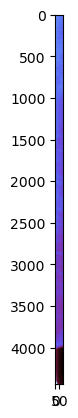

In [ ]:
_, binary_mask = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)

masked_image = cv2.bitwise_and(img, img, mask=binary_mask)

selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
opened_mask = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, selem)

contours, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key = cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

cropped_img = img[y:y+h, x:x+w]

norm_img = cv2.normalize(cropped_img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

magma = plt.get_cmap('magma')
colored_img = magma(norm_img)

colored_img = (colored_img * 255).astype(np.uint8)

# TODO:     image = cv2.resize(image, (224, 336))

colored_img = cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB)
plt.imshow(colored_img)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def create_model():
    """
    We used ResNet-50 pretrained on ImageNet [27 ];
    its architecture is based on residual learning, which allows increasing the depth of a CNN
    model that prevents the problem of gradient vanishing [31] and degradation [32,33].
    Text from Paper.
    """
    res_net1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    res_net2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base_model1 = Model(res_net1.input, res_net1.output, name='ResNet50_View1')
    base_model2 = Model(res_net2.input, res_net2.output, name='ResNet50_View2')

    for layer in base_model1.layers:
        layer.trainable = False

    for layer in base_model2.layers:
        layer.trainable = False

    input1 = Input(shape=(224, 224, 3))
    input2 = Input(shape=(224, 224, 3))

    features1 = base_model1(input1)
    features2 = base_model2(input2)

    flattened_features1 = Flatten()(features1)
    flattened_features2 = Flatten()(features2)

    """
    In our proposed method, the features from the two views are fused by the concatenation layer.
    Text from Paper.
    """
    concatenated = tf.keras.layers.concatenate([flattened_features1, flattened_features2])

    """
    The last layer of the model is the classification layer; it is a fully connected layer with
    four output neurons to classify the input views into one of the four breast density categories;
    each neuron represents a different BI-RADS class.

    SoftMax converts the numerical output of a convolutional neural network to class-specific probability values.
    """
    output = Dense(4, activation='softmax')(concatenated)

    model = Model(inputs=[input1, input2], outputs=output)

    optimizer = tf.keras.optimizers.SGD(learning_rate=1*10**-4, momentum=0.9)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 ResNet50_View1 (Functional)    (None, 7, 7, 2048)   23587712    ['input_3[0][0]']                
                                                                                              

In [2]:
from minio import Minio
import numpy as np
import io
import tensorflow as tf

# setup minio client
minioClient = Minio('127.0.0.1:9000',
                    access_key='vmOm8GPguREabcIk',
                    secret_key='8qWrIW80GwWnQ6cwHBERD1QPaTQu5lA8',
                    secure=False)

In [4]:
def load_and_preprocess(path):
    path = path.numpy().decode('utf-8')
    data = minioClient.get_object('pi-v1', path)
    img = np.load(io.BytesIO(data.read()), allow_pickle=True)
    label  = correct_cases.loc[file_names[0].split('/')[0]]['breast_density']
    return img, label

def tf_load_and_preprocess(path):
    image, label = tf.py_function(load_and_preprocess, [path], [tf.int32, tf.int32])
    return image, label

objects = minioClient.list_objects('pi-v1', recursive=True)
file_names = [obj.object_name for obj in objects if obj.object_name.endswith('.npy')]
file_names_dataset = tf.data.Dataset.from_tensor_slices(file_names)

file_names[:5]

['A_0002_1.LEFT_CC.npy/35898e7c36e24b0ea41a36f0cac50ff8_000000.npy',
 'A_0002_1.LEFT_CC.npy/cad27070c2374b0da7782cbb86d94791_000000.npy',
 'A_0002_1.LEFT_MLO.npy/8a73ab2f13bc4d31acc78f71801bb543_000000.npy',
 'A_0002_1.RIGHT_CC.npy/ec93624af0714a96a0f898d4fa3a6f3d_000000.npy',
 'A_0002_1.RIGHT_MLO.npy/fda02f4decb04a488ef41962bc3fee9f_000000.npy']

In [6]:
file_names_dataset = tf.data.Dataset.from_tensor_slices(file_names)
dataset = file_names_dataset.map(tf_load_and_preprocess)
batched_dataset = dataset.batch(64)

In [8]:
prefixes = [filename.split('/')[0] for filename in file_names]
prefixes[:5]

['A_0002_1.LEFT_CC.npy',
 'A_0002_1.LEFT_CC.npy',
 'A_0002_1.LEFT_MLO.npy',
 'A_0002_1.RIGHT_CC.npy',
 'A_0002_1.RIGHT_MLO.npy']

In [9]:
def search_by_filename(row):
    return row['patient_id'].replace('-', '_') + '.'+row['side']+'_'+row['view']+'.'+'npy'
cases['minio_path'] = cases.apply(search_by_filename, axis=1)

NameError: name 'cases' is not defined

In [135]:
def f(path):
    return [filename for filename in file_names if path in filename.split('/')][0]

correct_cases = correct_cases.copy()
correct_cases['minio_path'] = correct_cases['minio_path'].apply(f)
correct_cases

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
310,A-0706-1,2,LEFT,MLO,NaN,normals,NaN,3931,6406,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.LEFT_MLO.npy/3ddd03fced6d4d3bb2997afb...
311,A-0706-1,2,LEFT,CC,NaN,normals,NaN,3826,5581,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.LEFT_CC.npy/1c6675219e2a43ba8b7ece84f...
312,A-0706-1,2,RIGHT,MLO,NaN,normals,NaN,4441,5881,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.RIGHT_MLO.npy/47987bd6509641ff916a576...
313,A-0706-1,2,RIGHT,CC,NaN,normals,NaN,4126,5686,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.RIGHT_CC.npy/ad987b67855a439d97806013...
314,A-0567-1,1,RIGHT,MLO,NaN,normals,NaN,3136,5506,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0567_1.RIGHT_MLO.npy/05399fc40a69415bae84751...
...,...,...,...,...,...,...,...,...,...,...,...
10034,B-3173-1,2,RIGHT,MLO,NaN,benign_without_callbacks,NaN,3080,4568,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3173_1.RIGHT_MLO.npy/27fa6a04d2774a2cab221fd...
10084,B-3181-1,2,RIGHT,CC,NaN,benign_without_callbacks,NaN,3072,4568,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3181_1.RIGHT_CC.npy/098377c26a764e968d648949...
10100,B-3240-1,2,LEFT,MLO,NaN,benign_without_callbacks,NaN,4168,5680,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3240_1.LEFT_MLO.npy/cadf74c76eab4138a51be9b7...
10104,B-3231-1,3,RIGHT,CC,NaN,benign_without_callbacks,NaN,3120,4672,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3231_1.RIGHT_CC.npy/19c596bf6841482b9ddf2741...


In [169]:
cases[cases['minio_path'].apply(lambda path: not any(prefix in path for prefix in prefixes))]

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
0,D-4522-1,4,LEFT,MLO,NaN,normals,NaN,2596,5386,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.LEFT_MLO.npy
1,D-4522-1,4,RIGHT,CC,NaN,normals,NaN,2146,4726,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.RIGHT_CC.npy
2,D-4522-1,4,LEFT,CC,NaN,normals,NaN,2251,4576,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.LEFT_CC.npy
3,D-4522-1,4,RIGHT,MLO,NaN,normals,NaN,2296,5071,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.RIGHT_MLO.npy
4,D-4587-1,3,LEFT,MLO,NaN,normals,NaN,2506,5161,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4587_1.LEFT_MLO.npy
...,...,...,...,...,...,...,...,...,...,...,...
10408,B-3429-1,2,LEFT,MLO,NaN,benign_without_callbacks,NaN,3072,4440,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3429_1.LEFT_MLO.npy
10409,C-0464-1,4,LEFT,MLO,NaN,benign_without_callbacks,NaN,2816,4584,/home/cicese/condaProj/DDSM-ori/cases/processe...,C_0464_1.LEFT_MLO.npy
10410,C-0464-1,4,RIGHT,MLO,NaN,benign_without_callbacks,NaN,2872,4592,/home/cicese/condaProj/DDSM-ori/cases/processe...,C_0464_1.RIGHT_MLO.npy
10411,C-0464-1,4,LEFT,CC,NaN,benign_without_callbacks,NaN,2776,4592,/home/cicese/condaProj/DDSM-ori/cases/processe...,C_0464_1.LEFT_CC.npy


In [136]:
correct_cases.set_index('patient_id', inplace=True)
correct_cases

,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
patient_id,,,,,,,,,,
A-0706-1,2,LEFT,MLO,NaN,normals,NaN,3931,6406,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.LEFT_MLO.npy/3ddd03fced6d4d3bb2997afb...
A-0706-1,2,LEFT,CC,NaN,normals,NaN,3826,5581,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.LEFT_CC.npy/1c6675219e2a43ba8b7ece84f...
A-0706-1,2,RIGHT,MLO,NaN,normals,NaN,4441,5881,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.RIGHT_MLO.npy/47987bd6509641ff916a576...
A-0706-1,2,RIGHT,CC,NaN,normals,NaN,4126,5686,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0706_1.RIGHT_CC.npy/ad987b67855a439d97806013...
A-0567-1,1,RIGHT,MLO,NaN,normals,NaN,3136,5506,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0567_1.RIGHT_MLO.npy/05399fc40a69415bae84751...
...,...,...,...,...,...,...,...,...,...,...
B-3173-1,2,RIGHT,MLO,NaN,benign_without_callbacks,NaN,3080,4568,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3173_1.RIGHT_MLO.npy/27fa6a04d2774a2cab221fd...
B-3181-1,2,RIGHT,CC,NaN,benign_without_callbacks,NaN,3072,4568,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3181_1.RIGHT_CC.npy/098377c26a764e968d648949...
B-3240-1,2,LEFT,MLO,NaN,benign_without_callbacks,NaN,4168,5680,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3240_1.LEFT_MLO.npy/cadf74c76eab4138a51be9b7...


In [157]:
df_dataset = correct_cases.groupby('patient_id').agg(list)
df_dataset = df_dataset[df_dataset['minio_path'].map(len) >= 2]
df_dataset = df_dataset.reset_index()
df_dataset

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
0,A-0002-1,"[2, 2, 2, 2]","[LEFT, RIGHT, LEFT, RIGHT]","[CC, MLO, MLO, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[1979, 2129, 2039, 1874]","[4349, 5084, 5069, 4334]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0002_1.LEFT_CC.npy/35898e7c36e24b0ea41a36f0...
1,A-0003-1,"[3, 3, 3, 3]","[RIGHT, LEFT, LEFT, RIGHT]","[CC, CC, MLO, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2114, 2084, 2069, 2159]","[4679, 4514, 5159, 5399]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0003_1.RIGHT_CC.npy/aada481898a144678b2403c...
2,A-0005-1,"[4, 4, 4, 4]","[LEFT, LEFT, RIGHT, RIGHT]","[CC, MLO, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[1799, 1949, 1904, 2084]","[3959, 4454, 4139, 5099]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0005_1.LEFT_CC.npy/1180cda70fbd468ea9e0e0db...
3,A-0006-1,"[2, 2, 2, 2]","[RIGHT, RIGHT, LEFT, LEFT]","[CC, MLO, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2309, 2489, 2429, 2684]","[4994, 5459, 4874, 4979]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0006_1.RIGHT_CC.npy/640d1174e6fe4015a7247d2...
4,A-0009-1,"[4, 4, 4, 4]","[RIGHT, RIGHT, LEFT, LEFT]","[MLO, CC, MLO, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2954, 2684, 3224, 2969]","[5594, 5339, 5594, 5534]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0009_1.RIGHT_MLO.npy/0c94f36b344c40b89c230a...
...,...,...,...,...,...,...,...,...,...,...,...
1003,B-3041-1,"[3, 3, 3]","[LEFT, LEFT, RIGHT]","[MLO, CC, CC]","[nan, nan, nan]","[cancers, cancers, cancers]","[nan, nan, nan]","[3064, 3072, 3080]","[4664, 4616, 4592]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3041_1.LEFT_MLO.npy/47b2628cfeba422bbb4330b...
1004,B-3048-1,"[4, 4]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[cancers, cancers]","[nan, nan]","[3120, 3104]","[4680, 4768]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3048_1.RIGHT_CC.npy/9f305cd1430b4c8b8b638f1...
1005,B-3049-1,"[2, 2]","[LEFT, LEFT]","[MLO, CC]","[nan, nan]","[cancers, cancers]","[nan, nan]","[3096, 3096]","[4680, 4728]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3049_1.LEFT_MLO.npy/76ceac86b4cf495bb8a69eb...
1006,B-3056-1,"[4, 4]","[RIGHT, LEFT]","[CC, MLO]","[nan, nan]","[cancers, cancers]","[nan, nan]","[4040, 4072]","[5848, 5896]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3056_1.RIGHT_CC.npy/4cc0744df3da4a658a42bad...


In [87]:
correct_cases.loc[file_names[0].split('/')[0]]['breast_density']

2

In [104]:
correct_cases

,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path
patient_id,,,,,,,,,
A-0706-1,2,LEFT,MLO,NaN,normals,NaN,3931,6406,/home/cicese/condaProj/DDSM-ori/cases/processe...
A-0706-1,2,LEFT,CC,NaN,normals,NaN,3826,5581,/home/cicese/condaProj/DDSM-ori/cases/processe...
A-0706-1,2,RIGHT,MLO,NaN,normals,NaN,4441,5881,/home/cicese/condaProj/DDSM-ori/cases/processe...
A-0706-1,2,RIGHT,CC,NaN,normals,NaN,4126,5686,/home/cicese/condaProj/DDSM-ori/cases/processe...
A-0567-1,1,RIGHT,MLO,NaN,normals,NaN,3136,5506,/home/cicese/condaProj/DDSM-ori/cases/processe...
...,...,...,...,...,...,...,...,...,...
B-3173-1,2,RIGHT,MLO,NaN,benign_without_callbacks,NaN,3080,4568,/home/cicese/condaProj/DDSM-ori/cases/processe...
B-3181-1,2,RIGHT,CC,NaN,benign_without_callbacks,NaN,3072,4568,/home/cicese/condaProj/DDSM-ori/cases/processe...
B-3240-1,2,LEFT,MLO,NaN,benign_without_callbacks,NaN,4168,5680,/home/cicese/condaProj/DDSM-ori/cases/processe...


In [63]:
re.search(cases.loc[2]['minio_path'], 'A_0364_1.RIGHT_CC.npy/b745b769125b4029880dd41026af515d_000000.npy')

In [70]:
cases[cases['minio_path'] == 'A_0364_1.RIGHT_CC.npy']

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
576,A-0364-1,2,RIGHT,CC,NaN,normals,NaN,2821,5281,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0364_1.RIGHT_CC.npy


In [52]:
cases

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
0,D-4522-1,4,LEFT,MLO,NaN,normals,NaN,2596,5386,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.LEFT_MLO.npy
1,D-4522-1,4,RIGHT,CC,NaN,normals,NaN,2146,4726,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.RIGHT_CC.npy
2,D-4522-1,4,LEFT,CC,NaN,normals,NaN,2251,4576,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.LEFT_CC.npy
3,D-4522-1,4,RIGHT,MLO,NaN,normals,NaN,2296,5071,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4522_1.RIGHT_MLO.npy
4,D-4587-1,3,LEFT,MLO,NaN,normals,NaN,2506,5161,/home/cicese/condaProj/DDSM-ori/cases/processe...,D_4587_1.LEFT_MLO.npy
...,...,...,...,...,...,...,...,...,...,...,...
10408,B-3429-1,2,LEFT,MLO,NaN,benign_without_callbacks,NaN,3072,4440,/home/cicese/condaProj/DDSM-ori/cases/processe...,B_3429_1.LEFT_MLO.npy
10409,C-0464-1,4,LEFT,MLO,NaN,benign_without_callbacks,NaN,2816,4584,/home/cicese/condaProj/DDSM-ori/cases/processe...,C_0464_1.LEFT_MLO.npy
10410,C-0464-1,4,RIGHT,MLO,NaN,benign_without_callbacks,NaN,2872,4592,/home/cicese/condaProj/DDSM-ori/cases/processe...,C_0464_1.RIGHT_MLO.npy
10411,C-0464-1,4,LEFT,CC,NaN,benign_without_callbacks,NaN,2776,4592,/home/cicese/condaProj/DDSM-ori/cases/processe...,C_0464_1.LEFT_CC.npy


In [35]:
cases[cases['patient_id'] == 'A-0002-1']

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path
1254,A-0002-1,2,LEFT,CC,NaN,normals,NaN,1979,4349,/home/cicese/condaProj/DDSM-ori/cases/processe...
1255,A-0002-1,2,RIGHT,MLO,NaN,normals,NaN,2129,5084,/home/cicese/condaProj/DDSM-ori/cases/processe...
1256,A-0002-1,2,LEFT,MLO,NaN,normals,NaN,2039,5069,/home/cicese/condaProj/DDSM-ori/cases/processe...
1257,A-0002-1,2,RIGHT,CC,NaN,normals,NaN,1874,4334,/home/cicese/condaProj/DDSM-ori/cases/processe...


In [102]:
import pandas as pd

cases = pd.read_csv('http://127.0.0.1:9000/ddsm/ddsm_description_cases.csv')
cases.groupby('patient_id').agg(list)

,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path
patient_id,,,,,,,,,
A-0002-1,"[2, 2, 2, 2]","[LEFT, RIGHT, LEFT, RIGHT]","[CC, MLO, MLO, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[1979, 2129, 2039, 1874]","[4349, 5084, 5069, 4334]",[/home/cicese/condaProj/DDSM-ori/cases/process...
A-0003-1,"[3, 3, 3, 3]","[RIGHT, LEFT, LEFT, RIGHT]","[CC, CC, MLO, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2114, 2084, 2069, 2159]","[4679, 4514, 5159, 5399]",[/home/cicese/condaProj/DDSM-ori/cases/process...
A-0005-1,"[4, 4, 4, 4]","[LEFT, LEFT, RIGHT, RIGHT]","[CC, MLO, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[1799, 1949, 1904, 2084]","[3959, 4454, 4139, 5099]",[/home/cicese/condaProj/DDSM-ori/cases/process...
A-0006-1,"[2, 2, 2, 2]","[RIGHT, RIGHT, LEFT, LEFT]","[CC, MLO, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2309, 2489, 2429, 2684]","[4994, 5459, 4874, 4979]",[/home/cicese/condaProj/DDSM-ori/cases/process...
A-0009-1,"[4, 4, 4, 4]","[RIGHT, RIGHT, LEFT, LEFT]","[MLO, CC, MLO, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2954, 2684, 3224, 2969]","[5594, 5339, 5594, 5534]",[/home/cicese/condaProj/DDSM-ori/cases/process...
...,...,...,...,...,...,...,...,...,...
D-4605-1,"[2, 2, 2, 2]","[LEFT, LEFT, RIGHT, RIGHT]","[MLO, CC, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[3931, 3871, 4111, 4801]","[6481, 6571, 6601, 6586]",[/home/cicese/condaProj/DDSM-ori/cases/process...
D-4606-1,"[2, 2, 2, 2]","[RIGHT, LEFT, RIGHT, LEFT]","[MLO, CC, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[3796, 3901, 3736, 3586]","[6331, 6841, 6241, 6316]",[/home/cicese/condaProj/DDSM-ori/cases/process...
D-4607-1,"[1, 1, 1, 1]","[LEFT, RIGHT, LEFT, RIGHT]","[MLO, MLO, CC, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[4381, 4426, 4291, 4231]","[6211, 6541, 6676, 6811]",[/home/cicese/condaProj/DDSM-ori/cases/process...


In [ ]:
num_instances = len(df_dataset)

k = 5  # Number of folds
fold_size = num_instances // k

# Loop over folds
for fold_no in range(k):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no+1} ...')

    # Define train and validation datasets
    val_file_names = df_dataset[fold_no*fold_size:(fold_no+1)*fold_size]
    train_file_names = df_dataset[:fold_no*fold_size] + df_dataset[(fold_no+1)*fold_size:]
    
    fold_no += 1

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
0,A-0002-1,"[2, 2, 2, 2]","[LEFT, RIGHT, LEFT, RIGHT]","[CC, MLO, MLO, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[1979, 2129, 2039, 1874]","[4349, 5084, 5069, 4334]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0002_1.LEFT_CC.npy/35898e7c36e24b0ea41a36f0...
1,A-0003-1,"[3, 3, 3, 3]","[RIGHT, LEFT, LEFT, RIGHT]","[CC, CC, MLO, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2114, 2084, 2069, 2159]","[4679, 4514, 5159, 5399]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0003_1.RIGHT_CC.npy/aada481898a144678b2403c...
2,A-0005-1,"[4, 4, 4, 4]","[LEFT, LEFT, RIGHT, RIGHT]","[CC, MLO, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[1799, 1949, 1904, 2084]","[3959, 4454, 4139, 5099]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0005_1.LEFT_CC.npy/1180cda70fbd468ea9e0e0db...
3,A-0006-1,"[2, 2, 2, 2]","[RIGHT, RIGHT, LEFT, LEFT]","[CC, MLO, CC, MLO]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2309, 2489, 2429, 2684]","[4994, 5459, 4874, 4979]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0006_1.RIGHT_CC.npy/640d1174e6fe4015a7247d2...
4,A-0009-1,"[4, 4, 4, 4]","[RIGHT, RIGHT, LEFT, LEFT]","[MLO, CC, MLO, CC]","[nan, nan, nan, nan]","[normals, normals, normals, normals]","[nan, nan, nan, nan]","[2954, 2684, 3224, 2969]","[5594, 5339, 5594, 5534]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[A_0009_1.RIGHT_MLO.npy/0c94f36b344c40b89c230a...
...,...,...,...,...,...,...,...,...,...,...,...
1003,B-3041-1,"[3, 3, 3]","[LEFT, LEFT, RIGHT]","[MLO, CC, CC]","[nan, nan, nan]","[cancers, cancers, cancers]","[nan, nan, nan]","[3064, 3072, 3080]","[4664, 4616, 4592]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3041_1.LEFT_MLO.npy/47b2628cfeba422bbb4330b...
1004,B-3048-1,"[4, 4]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[cancers, cancers]","[nan, nan]","[3120, 3104]","[4680, 4768]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3048_1.RIGHT_CC.npy/9f305cd1430b4c8b8b638f1...
1005,B-3049-1,"[2, 2]","[LEFT, LEFT]","[MLO, CC]","[nan, nan]","[cancers, cancers]","[nan, nan]","[3096, 3096]","[4680, 4728]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3049_1.LEFT_MLO.npy/76ceac86b4cf495bb8a69eb...
1006,B-3056-1,"[4, 4]","[RIGHT, LEFT]","[CC, MLO]","[nan, nan]","[cancers, cancers]","[nan, nan]","[4040, 4072]","[5848, 5896]",[/home/cicese/condaProj/DDSM-ori/cases/process...,[B_3056_1.RIGHT_CC.npy/4cc0744df3da4a658a42bad...


In [167]:
from sklearn.model_selection import KFold
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True)
def load_and_preprocess(paths):
        images = []
        for path in paths:
            path = path.numpy().decode('utf-8')
            data = minioClient.get_object('pi-v1', path)
            images.append(np.load(io.BytesIO(data.read()), allow_pickle=True))
        return tuple(images)

def tf_load_and_preprocess(instance):
        path1, path2 = instance['minio_path'].values[0], instance['minio_path'].values[1]
        images = tf.numpy_function(load_and_preprocess, [[path1, path2]], [tf.int32, tf.int32, tf.int32])
        return images, instance['breast_density'].values[0]

    
# Loop over folds
fold_no = 1
for train_index, val_index in kf.split(df_dataset):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    train_instances = df_dataset.iloc[train_index]
    val_instances = df_dataset.iloc[val_index]


    train_dataset = tf.data.Dataset.from_tensor_slices(train_instances)
    train_dataset = train_dataset.map(tf_load_and_preprocess)
    train_dataset = train_dataset.batch(32)

    val_dataset = tf.data.Dataset.from_tensor_slices(val_instances)
    val_dataset = val_dataset.map(tf_load_and_preprocess)
    val_dataset = val_dataset.batch(32)

    model = create_model()
    history = model.fit(train_dataset, epochs=10, verbose=1, validation_data=val_dataset)

    fold_no += 1


------------------------------------------------------------------------
Training for fold 1 ...


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [24]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

kfold = KFold(n_splits=5, shuffle=True)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Iterate through the dataset
for train, test in kfold.split(dataset):
    model = create_model()

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Create a batched dataset for training
    train_dataset = train.batch(32)
    test_dataset = test.batch(32)

    history = model.fit(train_dataset, epochs=10, verbose=1)

    scores = model.evaluate(test_dataset, verbose=0)
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

TypeError: Singleton array array(<MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>,
      dtype=object) cannot be considered a valid collection.

In [ ]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')